# GoogLeNet

In [16]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [17]:
%matplotlib inline

In [18]:
if torch.cuda.is_available():
  DEVICE = 'cuda'
else:
  DEVICE = 'cpu'

In [19]:
DEVICE

'cuda'

In [31]:
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor()])

train_dataset = datasets.CIFAR10(root='cifar10', train=True, transform=transform, download = True)
valid_dataset = datasets.CIFAR10(root='cifar10', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size = 64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64)

Files already downloaded and verified


torch.Size([3, 32, 32]) 9


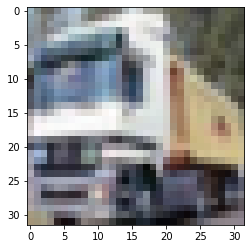

In [21]:
img, label = train_dataset[1]
print(img.shape, label)
img = img.numpy()

plt.imshow(img.transpose((1, 2, 0)))

In [22]:
class BasicConv2d(nn.Module):
  def __init__(self, in_channels, out_channels, **kwargs):
    super().__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
    self.bn = nn.BatchNorm2d(out_channels)

  def forward(self, x):
    x = self.conv(x)
    x = self.bn(x)
    return F.relu(x)

In [23]:
class Inception(nn.Module):
  def __init__(self, in_planes, n11, n33red, n33, n55red, n55, pool_planes):
    super().__init__()
    self.b1 = BasicConv2d(in_planes, n11, kernel_size=1)
    self.b21 = BasicConv2d(in_planes, n33red, kernel_size=1)
    self.b22 = BasicConv2d(n33red, n33, kernel_size=3, padding=1)

    self.b31 = BasicConv2d(in_planes, n55red, kernel_size=1)
    self.b32 = BasicConv2d(n55red, n55, kernel_size=5, padding=2)

    self.b41 = nn.MaxPool2d(3, stride=1, padding=1)
    self.b42 = BasicConv2d(in_planes, pool_planes, kernel_size=1)

  def forward(self, x):
    y1 = self.b1(x)
    y2 = self.b22(self.b21(x))
    y3 = self.b32(self.b31(x))
    y4 = self.b42(self.b41(x))

    return torch.cat([y1, y2, y3, y4], 1)

In [41]:
class GoogLeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.pre_layers = nn.Sequential(
        BasicConv2d(3, 64, kernel_size=7, stride=2, padding=3),
        nn.MaxPool2d(3, stride=2, padding=1),
        BasicConv2d(64, 192, kernel_size=3, padding=1),
        nn.MaxPool2d(3, stride=2, padding=1)
    )

    self.b = nn.Sequential(
        Inception(192, 64, 96, 128, 16, 32, 32),
        Inception(256, 128, 128, 192, 32, 96, 64),
        nn.MaxPool2d(3, stride=2, padding=1),
        Inception(480, 192,  96, 208, 16,  48,  64),
        Inception(512, 160, 112, 224, 24,  64,  64),
        Inception(512, 128, 128, 256, 24,  64,  64),
        Inception(512, 112, 144, 288, 32,  64,  64),
        Inception(528, 256, 160, 320, 32, 128, 128),
        nn.MaxPool2d(3, stride=2, padding=1),
        Inception(832, 256, 160, 320, 32, 128, 128),
        Inception(832, 384, 192, 384, 48, 128, 128),
        nn.AvgPool2d(7, stride=1),
        nn.Dropout(0.4)
    )

    self.c = nn.Sequential(
        nn.Linear(1024, 10)
    )

  def forward(self, x):
    y = self.pre_layers(x)
    y = self.b(y)
    y = torch.flatten(y, 1)
    logits = self.c(y)
    probs = F.softmax(logits, 1)
    return logits, probs


![GoogLeNet Architecture](GoogLeNet_architecture.png "GoogLeNet")

In [25]:
def train(train_loader, model, criterion, optimizer, device):
  model.train()
  running_loss = 0

  for X, y in train_loader:
    optimizer.zero_grad()
    X = X.to(device)
    y = y.to(device)
    y_hat, _ = model(X)
    loss = criterion(y_hat, y)
    running_loss += loss.item() * X.size(0)

    loss.backward()
    optimizer.step()

  epoch_loss = running_loss / len(train_loader.dataset)
  return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
  model.eval()
  running_loss = 0

  for X, y in valid_loader:
    optimizer.zero_grad()
    X = X.to(device)
    y = y.to(device)
    y_hat, _ = model(X)
    loss = criterion(y_hat, y)
    running_loss += loss.item() * X.size(0)

  epoch_loss = running_loss / len(valid_loader.dataset)
  return model, epoch_loss

def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device):
  best_loss = 1e10
  train_losses = []
  valid_losses = []

  for epoch in range(0, epochs):
    model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
    train_losses.append(train_loss)

    with torch.no_grad():
      model, valid_loss = validate(valid_loader, model, criterion, device)
      valid_losses.append(valid_loss)

    train_acc = get_accuracy(model, train_loader, device)
    valid_acc = get_accuracy(model, valid_loader, device)

    print(f'{datetime.now().time().replace(microsecond=0)} ---- '
          f'Epoch: {epoch}\t'
          f'Train Loss: {train_loss:.4f}\t'
          f'Valid Loss: {valid_loss:.4f}\t'
          f'Train Accuracy: {100 * train_acc:.2f}\t'
          f'Valid Accuracy: {100 * valid_acc:.2f}')
      
  plot_losses(train_losses, valid_losses)
  return model, optimizer, (train_losses, valid_losses)


def get_accuracy(model, data_loader, device):
  correct_pred = 0
  n = 0
  with torch.no_grad():
    model.eval()
    for X, y in data_loader:
      X = X.to(device)
      y = y.to(device)
      _, y_prob = model(X)
      _, predicted_labels = torch.max(y_prob, 1)

      n += y.size(0)
      correct_pred += (y == predicted_labels).sum()

    return correct_pred.float()/n

def plot_losses(train_losses, valid_losses):
  plt.style.use('seaborn')

  train_losses = np.array(train_losses)
  valid_losses = np.array(valid_losses)

  fig,ax = plt.subplots(figsize = (8, 4.5))

  ax.plot(train_losses, color='blue', label='Training loss')
  ax.plot(valid_losses, color='red', label='Validation loss')
  ax.set(title='Loss over epochs',  xlabel='Epoch', ylabel='loss')
  ax.legend()
  fig.show()

  plt.style.use('default')

In [42]:
model = GoogLeNet()
model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, 20, DEVICE)

09:50:50 ---- Epoch: 0	Train Loss: 1.4278	Valid Loss: 1.4406	Train Accuracy: 53.23	Valid Accuracy: 52.63
09:56:50 ---- Epoch: 1	Train Loss: 0.9414	Valid Loss: 0.9440	Train Accuracy: 69.34	Valid Accuracy: 67.42
10:02:51 ---- Epoch: 2	Train Loss: 0.7089	Valid Loss: 0.8610	Train Accuracy: 73.91	Valid Accuracy: 71.55
10:08:51 ---- Epoch: 3	Train Loss: 0.5760	Valid Loss: 0.5749	Train Accuracy: 83.83	Valid Accuracy: 79.87
10:14:50 ---- Epoch: 4	Train Loss: 0.4841	Valid Loss: 0.6112	Train Accuracy: 83.68	Valid Accuracy: 79.13
10:20:50 ---- Epoch: 5	Train Loss: 0.4121	Valid Loss: 0.5831	Train Accuracy: 86.14	Valid Accuracy: 80.99


KeyboardInterrupt: ignored